In [201]:
#import libraries
import numpy as np
import pandas as pd
import statistics as st
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plot
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,classification_report, auc
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score,RepeatedStratifiedKFold
import graphviz
import os
import csv
import random
import math
from sklearn.decomposition import PCA    
import seaborn as sb

In [202]:
def load_data():
    #read data
    df = pd.read_csv('Dataset.csv', header = 0)
    return df

In [203]:
def preprocess(df):
    #prepocessing
    df['PayCheck'] = df['PayCheck'].replace(np.nan, 'No')
    df['FinSupport'] = df['FinSupport'].replace(np.nan, 'No')
    df= df.replace('Yes',1)
    df= df.replace('No',0)
    df= df.replace('None',0)
    df= df.replace('Zero',0)
    Rng= ["1.0 - 0.99","2.0 - 2.99","3.0 - 3.99","4.0 - 4.99","5.0 - 5.99","6.0 - 6.99","7.0 - 7.99","8.0 - 8.99","9.0 - 10.0"]
    temp= 0.0
    for i in Rng:
        temp += 1
        df['CGPA']= df['CGPA'].replace(i,temp)
    data_types_dict = {'Age': 'int64', "Dependants" : 'int64', 'CGPA' : 'int64', 'FGGrad' : 'int64', 'Job' : 'int64', 'PayCheck' : 'int64', 'GradDegReq' : 'int64', 'Expertise' : 'int64', 'CareerShift' : 'int64','GradDegInterest' : 'int64', 'FinSupport' : 'int64', 'ActiveResearch' : 'int64', 'AcademicExposure' : 'int64', 'MastersDegree' : 'int64' }
    df = df.astype(data_types_dict)
    return df

In [204]:
def datadistribution(df):
    plot.figure(figsize = (20,15))
    dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True, fmt=".2f", annot_kws={'rotation': 45},square=True)
    plot.show()

In [205]:
def data_split(df):
    #splitting the data
    y,x = df[df.columns[15]],df[df.columns[2:15]]
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)
    return X_train, X_test, y_train, y_test

In [206]:
def standardization(X_train, X_test):
    sc_x = StandardScaler()
    X_train = sc_x.fit_transform(X_train) 
    X_test = sc_x.transform(X_test)
    return X_train, X_test

In [207]:
def print_scoremetrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print ("Confusion Matrix : \n", cm)
    ax = sb.heatmap(cm, annot=True, cmap='Blues')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    plot.show()
    print ("Accuracy : ", accuracy_score(y_test, y_pred))
    print ("F1 score : ", f1_score(y_test, y_pred))
    print("Report : ",classification_report(y_test, y_pred))
    zip_data = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)]
    return zip_data

In [208]:
def logistic_regression(X_train, X_test, y_train, y_test):
    print("******************************************************************************")
    print("The performance with logistic regression is as follows: ")
    classifier = LogisticRegression()
    #Defining hyperparameters for logistic regression
    solver_type = ['newton-cg', 'lbfgs', 'liblinear']
    penalty_type = ['l2']
    C_range = [100, 10, 1.0, 0.1, 0.01]
    
    #We are using grid search for tuning hyperparameters
    #K-fold cross validation
    param_grid = {"C": C_range, "penalty": penalty_type, "solver": solver_type}
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    
    # Define grid search
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=0)
    # Fit grid search
    grid_result = grid_search.fit(X_train, y_train)
    
    print('The best accuracy score for training dataset is '+ str(grid_result.best_score_*100))
    print('The best hyperparameters are '+str(grid_result.best_params_))
    print('The accuracy score for the testing dataset is '+str(grid_search.score(X_test, y_test)*100))
    
    #Modeling the parameters in the classifier
    best_C = grid_result.best_params_['C']
    best_penalty = grid_result.best_params_['penalty']
    best_solver = grid_result.best_params_['solver']


    #Evaluating logistic regression model
    classifier = LogisticRegression(C = best_C, penalty = best_penalty, solver = best_solver)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    zip_data = print_scoremetrics(y_test, y_pred)
    
    ns_probs = [0 for _ in range(len(y_test))]

    lr_probs = classifier.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

    return zip_data

In [209]:
def SVM(X_train, X_test, y_train, y_test):
    print("******************************************************************************")
    print("The performance with SVM is as follows: ")
    svc = SVC()
    #Defining hyperparameters C, gamma and kernel for SVM
    C_range = [ 0.01, 0.1,  1. , 10. ]
    gamma_range = [0.1, 1.0, 10.0, 'scale', 'auto']
    kernel_type = ['linear','poly']
    param_grid = {"C": C_range, "kernel": kernel_type, "gamma": gamma_range}
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    
    # Define grid search
    grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='accuracy',refit = 'accuracy', n_jobs=-1, cv=kfold, verbose=0)
    # Fit grid search
    grid_result = grid_search.fit(X_train, y_train)
    print('The best accuracy score for training dataset is '+ str(grid_result.best_score_*100))
    print('The best hyperparameters are '+str(grid_result.best_params_))
    print('The accuracy score for the testing dataset is '+str(grid_search.score(X_test, y_test)*100))
    
    #Modeling the parameters in the SVM
    best_C = grid_result.best_params_['C']
    best_gamma = grid_result.best_params_['gamma']
    best_kernel = grid_result.best_params_['kernel']
    
    #Evaluating the SVM model
    svc = SVC(C=best_C, gamma=best_gamma, kernel=best_kernel)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    
    zip_data = print_scoremetrics(y_test, y_pred)
    y_train_pred = svc.predict(X_train)
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred)

    plot.grid()

    plot.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
    plot.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
    plot.plot([0,1],[0,1],'g--')
    plot.legend()
    plot.xlabel("False Positive Rate")
    plot.ylabel("True Positive Rate")
    plot.title("AUC(ROC curve)")
    plot.grid(color='black', linestyle='-', linewidth=0.5)
    plot.show()
    return zip_data

In [210]:
def decision_tree(X_train, X_test, y_train, y_test):
    print("******************************************************************************")
    print("The performance with decision tree is as follows: ")
    tree = DecisionTreeClassifier(criterion= 'entropy')
    depth = np.arange(1,8, dtype = int)
    #We are using grid search for tuning hyperparameters
    #K-fold cross validation
    param_grid = {"max_depth": depth}
    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
    # Define grid search
    grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=0)
    # Fit grid search
    grid_result = grid_search.fit(X_train, y_train)
    
    
    print('The best accuracy score for training dataset is '+ str(grid_result.best_score_*100))
    print('The best hyperparameters are '+str(grid_result.best_params_))
    print('The accuracy score for the testing dataset is '+str(grid_search.score(X_test, y_test)*100))
    
    #Modeling the parameters in the Decision tree
    best_depth = grid_result.best_params_['max_depth']
    tree = DecisionTreeClassifier(criterion= 'entropy',max_depth = best_depth)
    
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    
    zip_data = print_scoremetrics(y_test, y_pred)
    return zip_data

In [211]:
def gradient_boosting(X_train, X_test, y_train, y_test):
    print("******************************************************************************")
    print("The performance with gradient boosting is as follows: ")
    GBC = GradientBoostingClassifier()
    n_estimators = [1, 10, 100, 1000]
    learning_rate = [0.001, 0.01, 0.1, 1]
    subsample = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    max_depth = [1, 3, 5, 7]
    param_grid = {"n_estimators": n_estimators, "learning_rate": learning_rate, "subsample": subsample,  "max_depth": max_depth}
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=GBC, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=0)
    # Fit grid search
    grid_result = grid_search.fit(X_train, y_train)
    print('The best accuracy score for training dataset is '+ str(grid_result.best_score_*100))
    print('The best hyperparameters are '+str(grid_result.best_params_))
    print('The accuracy score for the testing dataset is '+str(grid_search.score(X_test, y_test)*100))
    
    best_n_estimators = grid_result.best_params_['n_estimators']
    best_learning_rate = grid_result.best_params_['learning_rate']
    best_subsample = grid_result.best_params_['subsample']
    best_max_depth = grid_result.best_params_['max_depth']
    
    GBC = GradientBoostingClassifier(n_estimators = best_n_estimators, learning_rate = best_learning_rate, subsample = best_subsample, max_depth = best_max_depth)
    GBC.fit(X_train, y_train)
    y_pred = GBC.predict(X_test)
    
    zip_data = print_scoremetrics(y_test, y_pred)
    return zip_data

In [212]:
def ada_boost(X_train, X_test, y_train, y_test):
    print("******************************************************************************")
    print("The performance with adaboost is as follows: ")
    classifier = LogisticRegression(random_state=0)
    ABC = AdaBoostClassifier(base_estimator = classifier)
    n_estimators = [10, 50, 100, 500, 1000, 5000]
    learning_rate = [0.001, 0.01, 0.1, 1]
    param_grid = {"n_estimators": n_estimators, "learning_rate": learning_rate}
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=ABC, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=0)
    # Fit grid search
    grid_result = grid_search.fit(X_train, y_train)
    print('The best accuracy score for training dataset is '+ str(grid_result.best_score_*100))
    print('The best hyperparameters are '+str(grid_result.best_params_))
    print('The accuracy score for the testing dataset is '+str(grid_search.score(X_test, y_test)*100))
    
    best_n_estimators = grid_result.best_params_['n_estimators']
    best_learning_rate = grid_result.best_params_['learning_rate']
    
    ABC = AdaBoostClassifier(base_estimator = classifier, n_estimators = best_n_estimators, learning_rate = best_learning_rate)
    ABC.fit(X_train, y_train)
    y_pred = ABC.predict(X_test)
    
    zip_data = print_scoremetrics(y_test, y_pred)
    return zip_data

In [213]:
def partition(x):
    unique_values = np.unique(x)
    indices_dict = {i:np.asarray([],dtype=int) for i in unique_values}
    count = 0
    for i in x:
        indices_dict[i] = np.append(indices_dict[i],count)
        count +=1
    return indices_dict



def entropy(y, weights = None):
    total_size = y.shape[0]
    total_entropy = 0
    list_of_classes = np.unique(y)
    t_partition = partition(y)
    if weights is None:
        for i in list_of_classes:
            class_count= y[y==i].shape[0]
            p = class_count/total_size
            total_entropy += (-p * np.log2(p))
        return total_entropy
    if weights is not None:
        w_sum = np.sum(weights)
        for i in list_of_classes:
            partition_sum = 0
            for j in t_partition[i]: 
                partition_sum += weights[j]/w_sum
            p = partition_sum
        total_entropy += (-p * np.log2(p))
        return total_entropy
    
    
    
def mutual_information(x, y, weights = None):
    if weights is None:
        attribute_value_list = np.unique(x)
        total_size = y.shape[0]
        attribute_info = 0.0
        for attribute_value in attribute_value_list:
            attribute_value_data = x[x == attribute_value]
            label_value_data= y[x == attribute_value]
            attribute_value_count = attribute_value_data.shape[0]
            attribute_value_entropy = entropy(label_value_data)
            attribute_value_probability = attribute_value_count/total_size
            attribute_info += attribute_value_probability * attribute_value_entropy
        return entropy(y) - attribute_info   

    if weights is not None:
        w_sum = np.sum(weights)
        div = partition(x)
        attribute_info = 0.0
        for i in div.keys():
            partition_sum = 0.0
            for j in div[i]:
                partition_sum += weights[j]/w_sum
            attribute_info += partition_sum*entropy(y[x == i], weights)
        return entropy(y,weights) - attribute_info
    
    
def id3(x, y, attribute_value_pairs=None, depth=0, max_depth=5, weights=None):
    tree = {}
    w = weights
    if attribute_value_pairs is None:
        attribute_value_pairs=[]
        for i in range(x[0,:].shape[0]):
            for j in np.unique(x[:,i]):
                attribute_value_pairs += [(i,j)]
        attribute_value_pairs = np.asarray(attribute_value_pairs)       
    
    label_values, label_counts = np.unique(y, return_counts=True)

    if len(label_values) == 1:
        return label_values[0]

    if len(attribute_value_pairs) == 0 or depth == max_depth:
        return label_values[np.argmax(label_counts)]
    
    mutual_information_array = []
    for (i, v) in attribute_value_pairs:
        mutual_information_array += ([mutual_information(np.array(x[:, i] == v,dtype=int), y, w)])
    mutual_information_array= np.asarray(mutual_information_array)
    
    (attr, value) = attribute_value_pairs[np.argmax(mutual_information_array)]
    partitions = partition(np.array(x[:, attr] == value,dtype=int))
    attribute_value_pairs = np.delete(attribute_value_pairs, np.argwhere(np.all(attribute_value_pairs == (attr, value), axis=1)), 0)

    for split_val, indices in partitions.items():
        x_subset = np.take(x, indices, axis=0)
        y_subset = np.take(y, indices, axis=0)
        decision = bool(split_val)
        
        if weights is None:
            tree[(attr, value, decision)] = id3(x_subset, y_subset, attribute_value_pairs=attribute_value_pairs, max_depth=max_depth, depth=depth + 1)
        
        if weights is not None:
            w_subset = weights.take(indices, axis=0)
            tree[(attr, value, decision)] = id3(x_subset, y_subset, attribute_value_pairs=attribute_value_pairs, max_depth=max_depth, depth=depth + 1, weights = w_subset)

    return tree




def predict_example(x, tree):
    if type(tree) != dict:
        return tree
    for k in tree:
        res = x[k[0]] == k[1]
        if res == k[2]:
            return predict_example(x,tree[k])

        
def compute_error(y_true, y_pred, weights = None):
    if weights is None:
        n,sum = y_true.shape[0], 0
        for i,j in zip(y_true,y_pred):
            if(i!=j):
                sum +=1
        return (1/n)*sum

    if weights is not None:
        w_sum = np.sum(weights)
        n,sum = y_true.shape[0],0
        for i,j,k in zip(y_true,y_pred, range(n)):
            if(i!=j):
                sum += 1*weights[k]
        return sum/w_sum
        

        
        
def visualize(tree, depth=0):
    if depth == 0:
        print('TREE')

    for index, split_criterion in enumerate(tree):
        sub_trees = tree[split_criterion]

        # Print the current node: split criterion
        print('|\t' * depth, end='')
        print('+-- [SPLIT: x{0} = {1}]'.format(split_criterion[0], split_criterion[1]))

        # Print the children
        if type(sub_trees) is dict:
            visualize(sub_trees, depth + 1)
        else:
            print('|\t' * (depth + 1), end='')
            print('+-- [LABEL = {0}]'.format(sub_trees))
            
            
            
def bagging(x, y, max_depth, num_trees):
    bags = []
    for i in range(num_trees):
        random_x = []
        random_y = []
        for j in range(y.size):
            ind = random.randrange(y.size)
            random_x.append(x[ind,:])
            random_y.append(y[ind])
        tree = id3(np.array(random_x), np.array(random_y), depth = 0, max_depth = max_depth)
        bags.append(tree)
    return bags

def predict_bagging(x, bags):
    major_element = 0
    elements = []
    for i in range(len(bags)):
        elements.append(predict_example(x, bags[i]))
    major_element = max(elements, key=elements.count)
    return major_element

def adaboost(x, y, max_depth, num_stumps):
    trees = []
    x_length = len(x)
    weights = np.array([])
    
    for i in range(x_length):
        weights = np.append(weights,1/x_length)
    
    for j in range(num_stumps):
        train = id3(x, y, depth=0, max_depth=max_depth,weights = weights)
        y_pred = [predict_example(xin, train) for xin in x]

        error = np.sum(weights[y_pred != y])/np.sum(weights)
        alpha = math.log((1 - error)/error)/2
        
        for k in range(len(y_pred)):
            if y_pred[i] == y[i]:
                weights[i] *= np.exp(-alpha)
            else:
                weights[i] *= np.exp(alpha)
        
        weights = weights/np.sum(weights)
        trees.append((alpha,train))
    
    return trees

def predict_ensemble(x, h_ens):
    output = 0
    for i in range(len(h_ens)):
        for split, sub_tree in h_ens[i][1].items():
            attribute_number = split[0]
            attribute_value = split[1]
            decision = split[2]
        if decision == (x[attribute_number] == attribute_value):
            if type(sub_tree) is dict:
                label = predict_example(x, sub_tree)
            else:
                label = sub_tree
            
            output += int(label)*h_ens[i][0]

    if(output > 0.5):
        return 1
    else:
        return 0
            
def implement_decisiontrees(df,max_depth):
    df = load_data()
    df = preprocess(df)
    X_train, X_test, y_train, y_test = data_split(df)
    X_trn = X_train.to_numpy()
    X_tst = X_test.to_numpy()
    tree = id3(X_trn, y_train, attribute_value_pairs=None, depth=0, max_depth=max_depth, weights=None)
    y_pred = [predict_example(tst,tree) for tst in X_tst]
    print("The performance using decision trees - own implementation : ")
    zip_data = print_scoremetrics(y_test, y_pred)
    return zip_data

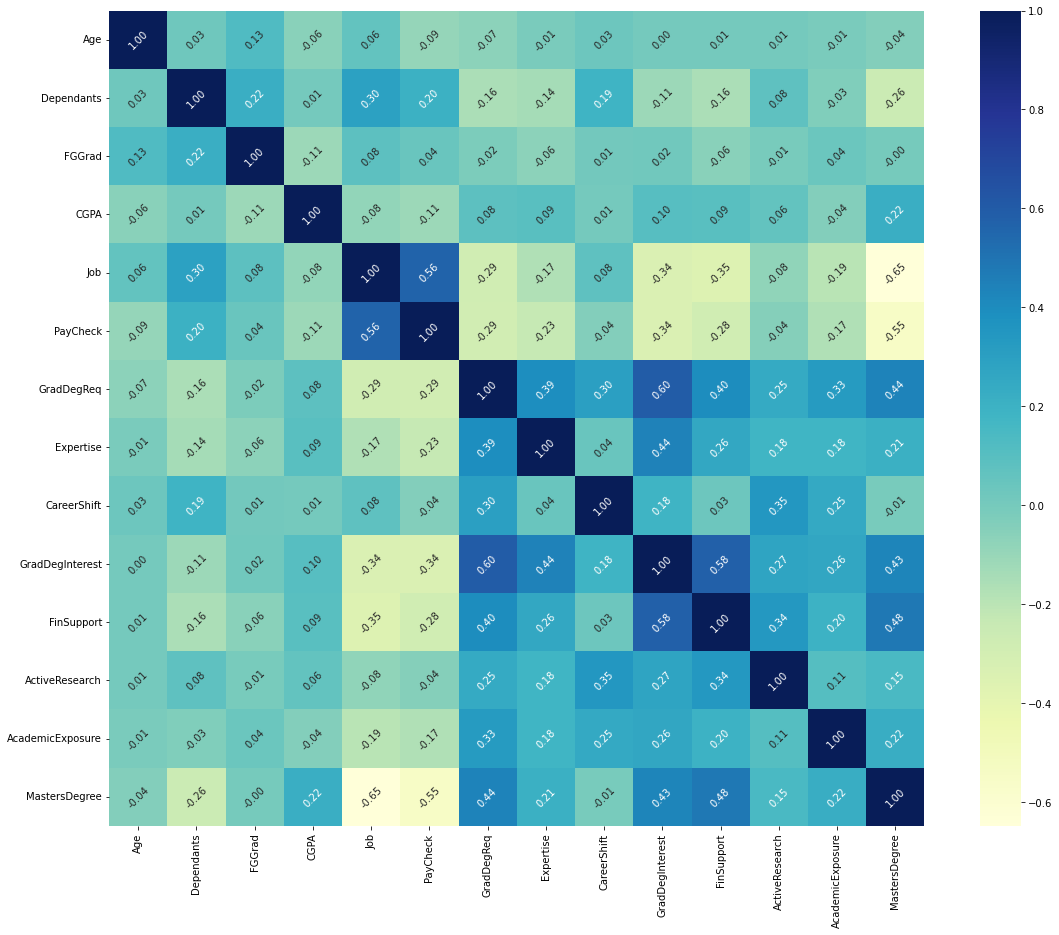

******************************************************************************
The performance with logistic regression is as follows: 
The best accuracy score for training dataset is 86.53968253968254
The best hyperparameters are {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
The accuracy score for the testing dataset is 83.6734693877551
Confusion Matrix : 
 [[17  1]
 [ 7 24]]


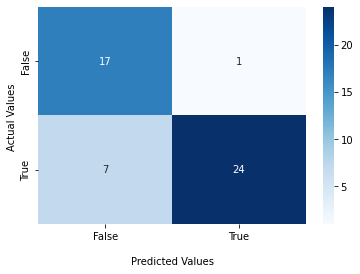

Accuracy :  0.8367346938775511
F1 score :  0.8571428571428571
Report :                precision    recall  f1-score   support

           0       0.71      0.94      0.81        18
           1       0.96      0.77      0.86        31

    accuracy                           0.84        49
   macro avg       0.83      0.86      0.83        49
weighted avg       0.87      0.84      0.84        49



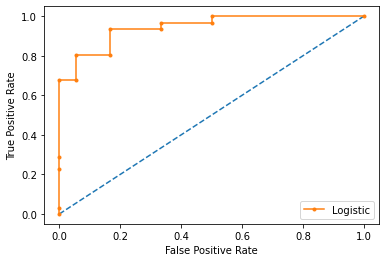

******************************************************************************
The performance with SVM is as follows: 
The best accuracy score for training dataset is 80.13038548752834
The best hyperparameters are {'C': 1.0, 'gamma': 0.1, 'kernel': 'linear'}
The accuracy score for the testing dataset is 77.55102040816327
Confusion Matrix : 
 [[15  3]
 [ 8 23]]


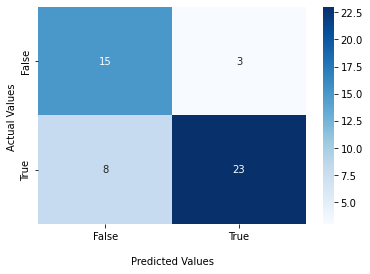

Accuracy :  0.7755102040816326
F1 score :  0.8070175438596492
Report :                precision    recall  f1-score   support

           0       0.65      0.83      0.73        18
           1       0.88      0.74      0.81        31

    accuracy                           0.78        49
   macro avg       0.77      0.79      0.77        49
weighted avg       0.80      0.78      0.78        49



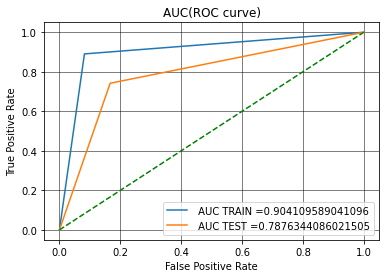

******************************************************************************
The performance with decision tree is as follows: 
The best accuracy score for training dataset is 82.92042042042043
The best hyperparameters are {'max_depth': 1}
The accuracy score for the testing dataset is 79.59183673469387
Confusion Matrix : 
 [[17  1]
 [ 9 22]]


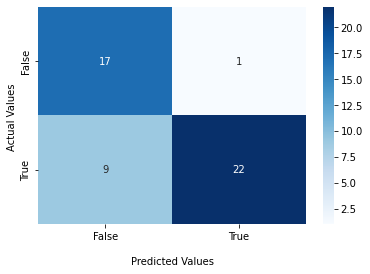

Accuracy :  0.7959183673469388
F1 score :  0.8148148148148149
Report :                precision    recall  f1-score   support

           0       0.65      0.94      0.77        18
           1       0.96      0.71      0.81        31

    accuracy                           0.80        49
   macro avg       0.81      0.83      0.79        49
weighted avg       0.85      0.80      0.80        49

The performance using decision trees - own implementation : 
Confusion Matrix : 
 [[17  1]
 [ 9 22]]


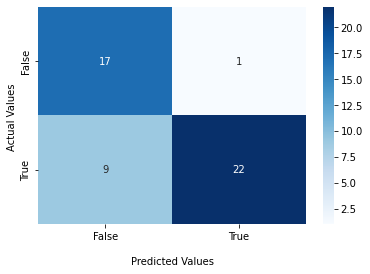

Accuracy :  0.7959183673469388
F1 score :  0.8148148148148149
Report :                precision    recall  f1-score   support

           0       0.65      0.94      0.77        18
           1       0.96      0.71      0.81        31

    accuracy                           0.80        49
   macro avg       0.81      0.83      0.79        49
weighted avg       0.85      0.80      0.80        49

The best accuracy score for training dataset is 87.87301587301587
The best hyperparameters are {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100, 'subsample': 0.8}
The accuracy score for the testing dataset is 83.6734693877551
Confusion Matrix : 
 [[18  0]
 [ 7 24]]


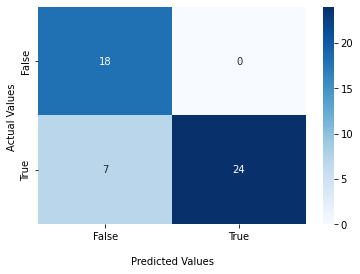

Accuracy :  0.8571428571428571
F1 score :  0.8727272727272727
Report :                precision    recall  f1-score   support

           0       0.72      1.00      0.84        18
           1       1.00      0.77      0.87        31

    accuracy                           0.86        49
   macro avg       0.86      0.89      0.85        49
weighted avg       0.90      0.86      0.86        49

The best accuracy score for training dataset is 87.46031746031746
The best hyperparameters are {'learning_rate': 1, 'n_estimators': 10}
The accuracy score for the testing dataset is 77.55102040816327
Confusion Matrix : 
 [[16  2]
 [ 9 22]]


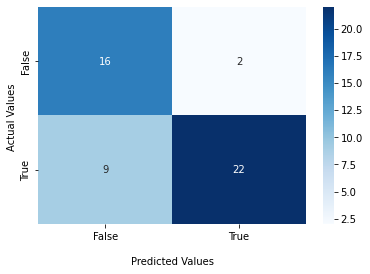

Accuracy :  0.7755102040816326
F1 score :  0.7999999999999999
Report :                precision    recall  f1-score   support

           0       0.64      0.89      0.74        18
           1       0.92      0.71      0.80        31

    accuracy                           0.78        49
   macro avg       0.78      0.80      0.77        49
weighted avg       0.82      0.78      0.78        49



In [214]:
df = load_data()
df = preprocess(df)
datadistribution(df)
X_train, X_test, y_train, y_test = data_split(df)
X_trn = X_train.to_numpy()
X_tst = X_test.to_numpy()
tree = id3(X_trn, y_train, attribute_value_pairs=None, depth=0, max_depth=5, weights=None)
X_train_std, X_test_std = standardization(X_train, X_test)
lr = logistic_regression(X_train_std, X_test_std, y_train, y_test)
sv = SVM(X_train_std, X_test_std, y_train, y_test)
dt = decision_tree(X_train_std, X_test_std, y_train, y_test)
idt = implement_decisiontrees(df,1)
gb = gradient_boosting(X_train_std, X_test_std, y_train, y_test)
ada = ada_boost(X_train_std, X_test_std, y_train, y_test)

In [215]:
#calculating the MSE
def calculate_cost(X, centroids, cluster):
    sum = 0
    for i, val in enumerate(X):
        sum += np.sqrt((centroids[int(cluster[i]), 0]-val[0])**2 +(centroids[int(cluster[i]), 1]-val[1])**2)
    return sum



def kmeans(X, k):
    diff = 1
    cluster = np.zeros(X.shape[0])
    centroids = principalDf.sample(n=k).values
    while diff:
        for i, row in enumerate(X):
            mn_dist = float('inf')
            for idx, centroid in enumerate(centroids):
                d = np.sqrt((centroid[0]-row[0])**2 + (centroid[1]-row[1])**2)
                if mn_dist > d:
                    mn_dist = d
                    cluster[i] = idx
        new_centroids = pd.DataFrame(X).groupby(by=cluster).mean().values
        print(centroids.shape, new_centroids.shape)
        if np.count_nonzero(centroids-new_centroids) == 0:
            diff = 0
        else:
            centroids = new_centroids
    return centroids, cluster

In [216]:
def Unsupervised():
    y,x = df[df.columns[15]],df[df.columns[2:15]]
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(data)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    
    
    cost_list = []
    for k in range(1, 10):
        centroids, cluster = kmeans(principalDf.values, k)
        cost = calculate_cost(principalDf.values, centroids, cluster)
        cost_list.append(cost)
        
    sb.lineplot(x=range(1,10), y=cost_list, marker='o')
    plot.xlabel('k')
    plot.ylabel('WCSS')
    plot.show()
    X = principalDf.values
    centroids, cluster = kmeans(X, 2)
    
    if(cluster[0] == 0):
        y_pred = np.zeros((X.shape[0]), dtype=int)
        for i in range(cluster.shape[0]):
            if cluster[i] == 0:
                y_pred[i] = 1
        cluster = y_pred    
    print_scoremetrics(cluster, y)

(1, 2) (1, 2)
(1, 2) (1, 2)
(2, 2) (2, 2)
(2, 2) (2, 2)
(2, 2) (2, 2)
(2, 2) (2, 2)
(2, 2) (2, 2)
(2, 2) (2, 2)
(2, 2) (2, 2)
(2, 2) (2, 2)
(2, 2) (2, 2)
(2, 2) (2, 2)
(2, 2) (2, 2)
(3, 2) (3, 2)
(3, 2) (3, 2)
(3, 2) (3, 2)
(3, 2) (3, 2)
(3, 2) (3, 2)
(3, 2) (3, 2)
(3, 2) (3, 2)
(3, 2) (3, 2)
(3, 2) (3, 2)
(3, 2) (3, 2)
(4, 2) (4, 2)
(4, 2) (4, 2)
(4, 2) (4, 2)
(4, 2) (4, 2)
(4, 2) (4, 2)
(5, 2) (5, 2)
(5, 2) (5, 2)
(5, 2) (5, 2)
(5, 2) (5, 2)
(5, 2) (5, 2)
(5, 2) (5, 2)
(5, 2) (5, 2)
(5, 2) (5, 2)
(5, 2) (5, 2)
(5, 2) (5, 2)
(6, 2) (6, 2)
(6, 2) (6, 2)
(6, 2) (6, 2)
(6, 2) (6, 2)
(6, 2) (6, 2)
(6, 2) (6, 2)
(6, 2) (6, 2)
(6, 2) (6, 2)
(6, 2) (6, 2)
(6, 2) (6, 2)
(7, 2) (7, 2)
(7, 2) (7, 2)
(7, 2) (7, 2)
(7, 2) (7, 2)
(7, 2) (7, 2)
(7, 2) (7, 2)
(7, 2) (7, 2)
(7, 2) (7, 2)
(7, 2) (7, 2)
(7, 2) (7, 2)
(7, 2) (7, 2)
(7, 2) (7, 2)
(7, 2) (7, 2)
(7, 2) (7, 2)
(7, 2) (7, 2)
(8, 2) (8, 2)
(8, 2) (8, 2)
(8, 2) (8, 2)
(8, 2) (8, 2)
(8, 2) (8, 2)
(8, 2) (8, 2)
(8, 2) (8, 2)
(8, 2) (8, 2)
(8, 2)

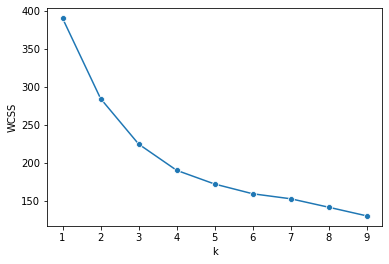

(2, 2) (2, 2)
(2, 2) (2, 2)
(2, 2) (2, 2)
(2, 2) (2, 2)
(2, 2) (2, 2)
(2, 2) (2, 2)
(2, 2) (2, 2)
(2, 2) (2, 2)
(2, 2) (2, 2)
(2, 2) (2, 2)
Confusion Matrix : 
 [[ 44   3]
 [ 47 101]]


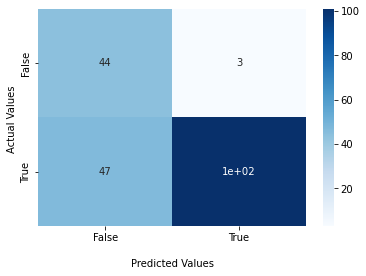

Accuracy :  0.7435897435897436
F1 score :  0.8015873015873016
Report :                precision    recall  f1-score   support

         0.0       0.48      0.94      0.64        47
         1.0       0.97      0.68      0.80       148

    accuracy                           0.74       195
   macro avg       0.73      0.81      0.72       195
weighted avg       0.85      0.74      0.76       195



In [217]:
Unsupervised()

In [218]:
MLA_columns = []
MLA = [lr, sv, dt, idt, gb, ada]
MLA_compare = pd.DataFrame(columns = MLA_columns)
MLA_names = ["Logistic Regression", "SVM", "Decision Trees","Implemented Decision Trees","Gradient Boosting", "Ada Boost"]
row_index = 0
for alg,MLA_name in zip(MLA,MLA_names):  
    
    MLA_compare.loc[row_index,'Model used'] = MLA_name
    MLA_compare.loc[row_index, 'Test Accuracy'] = round(alg[0], 4)
    MLA_compare.loc[row_index, 'F1 Score'] = round(alg[1], 4)


    row_index+=1
       
MLA_compare

,Model used,Test Accuracy,F1 Score
0,Logistic Regression,0.8367,0.8571
1,SVM,0.7755,0.8070
2,Decision Trees,0.7959,0.8148
3,Implemented Decision Trees,0.7959,0.8148
4,Gradient Boosting,0.8571,0.8727
5,Ada Boost,0.7755,0.8000
